#INSTALLING DEPENDENCIES

In [2]:
! pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np
import random
import gym
from gym import spaces
import matplotlib.pyplot as plt
import pickle
import cv2
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from google.colab import widgets

In [178]:
'''Creating dictionary to store the states as numbers from 0 to 15'''
AGENT_POSITIONS= dict()

k= 0
for i in range(4):
  for j in range(4):
    AGENT_POSITIONS[(i, j)]= k
    k+= 1
print(k)

16


#DEFINE ENVIRONMENT

In [179]:
class RoadToQatar(gym.Env):
    """This class implements the Road To Qatar environment."""

    def __init__(self, max_timesteps, env_type):

        self.max_timesteps = max_timesteps
        self.environment = env_type

        self.environment_width = 4
        self.environment_height = 4
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)

        self.agent_pos = np.asarray([0, 0])
        self.goal_pos = np.asarray([[3, 0], [3, 2], [0, 3]])
        self.energy_pos = np.asarray([[1, 0],[0, 2]])
        self.miss_pos = np.asarray([[2, 0], [2, 2]])
        self.world_cup = np.asarray([3, 3])
        self.tackle_pos = np.asarray([[1, 1], [2, 3]])
        self.redcard_pos = np.asarray([1, 2])

        '''Count of each rewardin the environment'''
        self.goal_counts = len(self.goal_pos)
        self.energy_counts = len(self.energy_pos)
        self.miss_counts = len(self.miss_pos)
        self.tackle_counts = len(self.tackle_pos)
        self.redcard_counts = len(self.redcard_pos)

    def reset(self):
        self.timestep = 0
        self.agent_pos = np.asarray([0, 0])
        self.goal_pos = np.asarray([[3, 0], [3, 2], [0, 3]])
        self.energy_pos = np.asarray([[1, 0],[0, 2]])
        self.miss_pos = np.asarray([[2, 0], [2, 2]])
        self.world_cup = np.asarray([3, 3])
        self.tackle_pos = np.asarray([[1, 1], [2, 3]])
        self.redcard_pos = np.asarray([1, 2])

        self.state = np.zeros((4, 4))

        self.goal_counts = len(self.goal_pos)
        self.energy_counts = len(self.energy_pos)
        self.miss_counts = len(self.miss_pos)
        self.tackle_counts = len(self.tackle_pos)
        self.redcard_counts = len(self.redcard_pos)
      
        return AGENT_POSITIONS[tuple(self.agent_pos)]


    def step(self, action):
        '''this part of code runs when the environment is Stochastic. The stochasticity is set at only two states in the environment - [1, 1], [2, 3]. 
          The agent picks a new action everytime the random number generated is greater than 0.3'''
        if (self.environment == 'Stochastic' and any(np.array_equal(self.agent_pos, self.tackle_pos[i]) for i in range(len(self.tackle_pos)))):
          temp = random.uniform(0,1)
          if temp > 0.3:
            action_new = random.choice([i for i in range(4) if i != action])
            # print("Action = "+str(action))
            action = action_new
            # print("Action_new = "+str(action))

        # Describing the outcomes of the various possible actions.
        if action == 0:
            self.agent_pos[0] += 1  # This action causes the agent to go right.
        if action == 1:
            self.agent_pos[0] -= 1  # This action causes the agent to go left.
        if action == 2:
            self.agent_pos[1] += 1  # This action causes the agent to go up.
        if action == 3:
            self.agent_pos[1] -= 1  # This action causes the agent to go down.
        
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        
        reward = 0
        if (self.agent_pos == self.world_cup).all():
            reward += 20
        if self.energy_counts > 0: 
            for x in range(len(self.energy_pos)):
              if (self.agent_pos == self.energy_pos[x]).all():
                reward += 5
                self.energy_pos = np.delete(self.energy_pos,x,axis=0)
                self.energy_counts -= 1
              break
        if self.goal_counts > 0:
            for x in range(len(self.goal_pos)):
              if (self.agent_pos == self.goal_pos[x]).all():
                reward += 10
                self.goal_pos = np.delete(self.goal_pos,x,axis=0)
                self.goal_counts -= 1
              break
        if self.miss_counts > 0:
           for x in range(len(self.miss_pos)):
             if (self.agent_pos == self.miss_pos[x]).all():
                reward -= 3
                self.miss_pos = np.delete(self.miss_pos,x,axis=0)        
                self.miss_counts -= 1
             break
        if self.tackle_counts > 0:
            for x in range(len(self.tackle_pos)):
              if (self.agent_pos == self.tackle_pos[x]).all():
                reward -= 5
                self.tackle_pos = np.delete(self.tackle_pos,x,axis=0)
                self.tackle_counts -= 1
              break
        if self.redcard_counts > 0 and (self.agent_pos == self.redcard_pos).all():
            reward -= 10
            self.redcard_pos = np.delete(self.redcard_pos,0,axis=0)
            self.redcard_counts -= 1
        
        self.timestep += 1
        done = True if (self.timestep >= self.max_timesteps or (self.agent_pos == self.world_cup).all()) else False
        
        info = {}
        
        return AGENT_POSITIONS[tuple(self.agent_pos)], reward, done, info

    def render(self, mode='human', plot=False):

        fig, ax = plt.subplots(figsize=(10, 10))
        # ax.set_facecolor('#5ca904')
        ax.set_xlim(0, 4)
        ax.set_ylim(0, 4)
        plt.xticks(None)

        def plot_image(plot_pos):
            # Initially setting every object to not be plotted.
            plot_agent, plot_cup, plot_goal, plot_energy, plot_miss, plot_tackle, plot_redcard = \
                False, False, False, False, False, False,False

            # Checking which objects need to be plotted by comparing their positions.
            if np.array_equal(self.agent_pos, plot_pos):
                plot_agent = True
            if any(np.array_equal(self.goal_pos[i], plot_pos) for i in range(len(self.goal_pos))):
                plot_goal = True
            if any(np.array_equal(plot_pos, self.energy_pos[i]) for i in range(len(self.energy_pos))):
                plot_energy = True
            if np.array_equal(plot_pos,self.world_cup):
                plot_cup = True
            if any(np.array_equal(self.miss_pos[i], plot_pos) for i in range(len(self.miss_pos))):
                plot_miss = True
            if any(np.array_equal(self.tackle_pos[i], plot_pos) for i in range(len(self.tackle_pos))):
                plot_tackle = True
            if np.array_equal(plot_pos, self.redcard_pos):
                plot_redcard = True

            # Plot for Agent.
            if plot_agent and all(not item for item in [plot_goal, plot_energy, plot_miss, plot_tackle, plot_redcard]):
                agent = AnnotationBbox(OffsetImage(plt.imread('/content/leo.png'), zoom=0.6),np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent)

            #Plot for WC
            elif plot_cup and all(not item for item in [plot_agent, plot_goal, plot_energy, plot_miss, plot_tackle, plot_redcard]):
                world_cup = AnnotationBbox(OffsetImage(plt.imread('/content/World_Cup.jpg'), zoom=0.28),np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(world_cup)

            # Plot for Goal.
            elif plot_goal and all(not item for item in [plot_agent, plot_energy, plot_miss, plot_tackle, plot_redcard]):
                goal = AnnotationBbox(OffsetImage(plt.imread('/content/goal.png'), zoom=0.58),np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(goal)

            # Plot for Energy.
            elif plot_energy and all(not item for item in [plot_agent, plot_goal, plot_miss, plot_tackle, plot_redcard]):
                energy = AnnotationBbox(OffsetImage(plt.imread('/content/energy.png'), zoom=0.58),np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(energy)

            # Plot for Miss.
            elif plot_miss and all(not item for item in [plot_agent, plot_goal, plot_energy, plot_tackle, plot_redcard]):
                pit = AnnotationBbox(OffsetImage(plt.imread('/content/miss.png'), zoom=0.58),np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(pit)

            # Plot for Tackle.
            elif plot_tackle and all(not item for item in [plot_agent, plot_goal, plot_energy, plot_miss, plot_redcard]):
                tackle = AnnotationBbox(OffsetImage(plt.imread('/content/tackle.png'), zoom=0.58),np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(tackle)

            # Plot for Redcard.
            elif plot_redcard and all(not item for item in [plot_agent, plot_goal, plot_energy, plot_miss, plot_tackle]):
                redcard = AnnotationBbox(OffsetImage(plt.imread('/content/redcard.jpg'), zoom=0.12),np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(redcard)

            # Plot for Agent and Energy.
            elif all(item for item in [plot_agent, plot_energy]) and all(not item for item in [plot_miss, plot_tackle, plot_goal, plot_redcard]):
                agent = AnnotationBbox(OffsetImage(plt.imread('/content/leo.png'), zoom=0.6),np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent)

            # Plot for Agent and Goal.
            elif all(item for item in [plot_agent, plot_goal]) and all(not item for item in [plot_miss, plot_tackle, plot_energy, plot_redcard]):
                agent = AnnotationBbox(OffsetImage(plt.imread('/content/leo.png'), zoom=0.6),np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent)

            # Plot for Agent and Tackle.
            elif all(item for item in [plot_agent, plot_tackle]) and all(not item for item in [plot_miss, plot_energy, plot_goal, plot_redcard]):
                agent = AnnotationBbox(OffsetImage(plt.imread('/content/leo.png'), zoom=0.6),np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent)
            
            # Plot for Agent and Miss.
            elif all(item for item in [plot_agent, plot_miss]) and all(not item for item in [plot_tackle, plot_energy, plot_goal, plot_redcard]):
                agent = AnnotationBbox(OffsetImage(plt.imread('/content/leo.png'), zoom=0.6),np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent)

            
        coordinates_state_mapping_2 = {}
        for j in range(self.environment_height * self.environment_width):
            coordinates_state_mapping_2[j] = np.asarray(
                [j % self.environment_width, int(np.floor(j / self.environment_width))])

        # Rendering the images for all states.
        for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])

        plt.xticks([0, 1, 2, 3])
        plt.yticks([0, 1, 2, 3])
        plt.grid()  # Setting the plot to be of the type 'grid'.

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 84
            height = 84
            dim = (width, height)
            # noinspection PyUnresolvedReferences
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()
            return preprocessed_image



In [180]:
class RandomAgent:
  """This class implements the agent"""
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, observation):
    return np.random.choice(self.action_space.n)

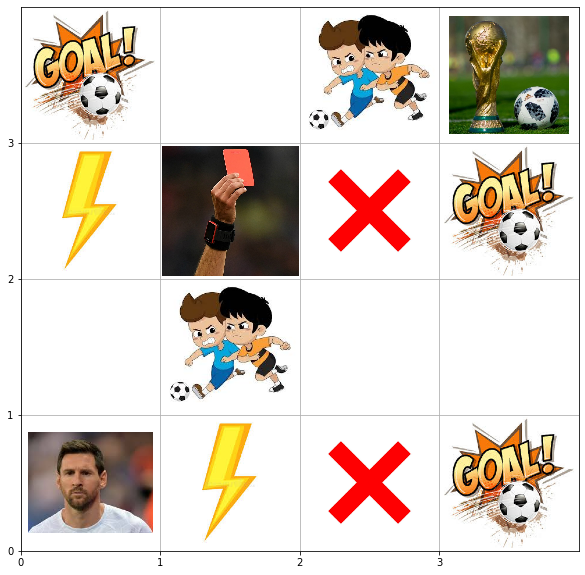

In [181]:
'''Start state of the agent'''
det_env = RoadToQatar(10, 'Deterministic')
agent = RandomAgent(det_env)
obs = det_env.reset()
det_env.render(plot=True)

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Agent takes RIGHT action


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Agent takes UP action


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

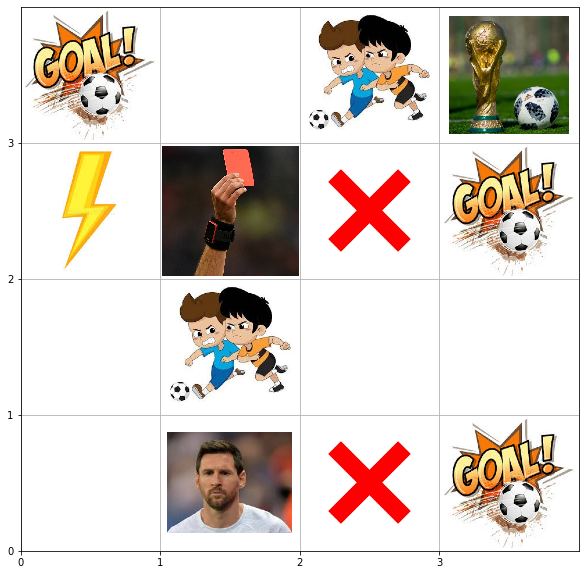

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

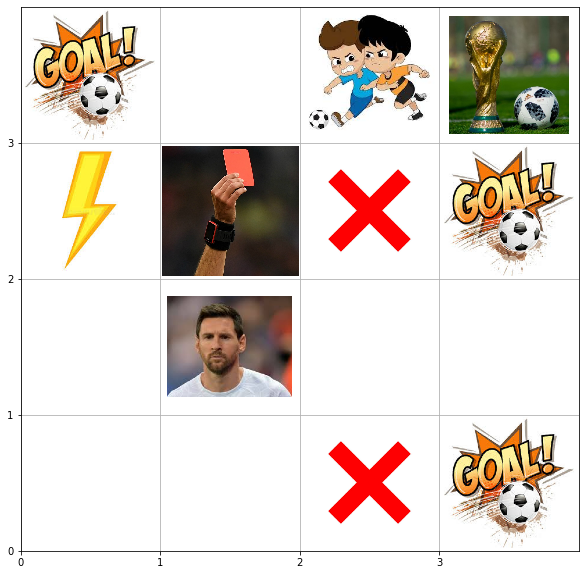

<IPython.core.display.Javascript object>

In [99]:
grid = widgets.Grid(2,2)

with grid.output_to(0,0):
  print("Agent takes RIGHT action")

with grid.output_to(0,1):
  print("Agent takes UP action")

with grid.output_to(1,0):
  det_env.step(0)
  det_env.render(plot=True)

with grid.output_to(1,1):
  det_env.step(2)
  det_env.render(plot=True)

###Running agent in Deterministic Environment

In [100]:

done = False

# output_grid = widgets.Grid(1, 1)
# with output_grid.output_to(0, 0):
#   env.render()

i=0
while not done:
  action = agent.step(obs)
  obs, reward, done, info = det_env.step(action)
  print("At timestep " + str(i) + ", Agent position: " + str(det_env.agent_pos) + " Reward: " + str(reward))
  i = i + 1
  # env.render(plot=True)
  time.sleep(1)

At timestep 0, Agent position: [1 2] Reward: -10
At timestep 1, Agent position: [1 3] Reward: 0
At timestep 2, Agent position: [1 3] Reward: 0
At timestep 3, Agent position: [1 3] Reward: 0
At timestep 4, Agent position: [1 2] Reward: 0
At timestep 5, Agent position: [1 3] Reward: 0
At timestep 6, Agent position: [2 3] Reward: -5
At timestep 7, Agent position: [2 3] Reward: 0


###Running agent in Stochastic Environment

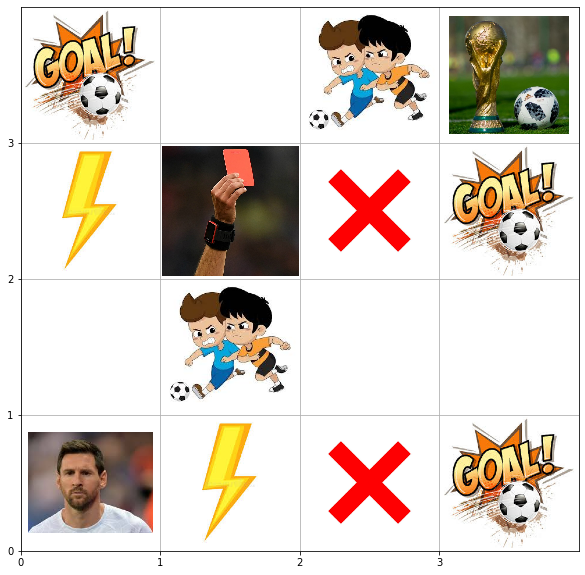

In [101]:
stoc_env = RoadToQatar(10, 'Stochastic')
agent = RandomAgent(stoc_env)
obs = stoc_env.reset()
stoc_env.render(plot=True)

In [102]:
done = False

# output_grid = widgets.Grid(1, 1)
# with output_grid.output_to(0, 0):
#   env.render()

i=0
while not done:
  action = agent.step(obs)
  obs, reward, done, info = stoc_env.step(action)
  print("At timestep " + str(i) + ", Agent position: " + str(stoc_env.agent_pos) + " Reward: " + str(reward))
  i = i + 1
  # env.render(plot=True)
  time.sleep(1)

At timestep 0, Agent position: [0 1] Reward: 0
At timestep 1, Agent position: [0 0] Reward: 0
At timestep 2, Agent position: [0 0] Reward: 0
At timestep 3, Agent position: [1 0] Reward: 5
At timestep 4, Agent position: [1 0] Reward: 0
At timestep 5, Agent position: [0 0] Reward: 0
At timestep 6, Agent position: [0 0] Reward: 0
At timestep 7, Agent position: [1 0] Reward: 0
At timestep 8, Agent position: [1 1] Reward: -5
At timestep 9, Agent position: [2 1] Reward: 0


#Q-LEARNING

In [121]:
class Q_Learning_Agent(RandomAgent):

  def __init__(self, env, discount_rate= 0.99, learning_rate= 0.1, epsilon= 1.0):
    ''' This class initializes a Q-learning agent with gamma = 0.99, alpha = 0.1 and epsilon = 1.0'''
    super().__init__(env)
    self.epsilon= epsilon
    self.gamma= discount_rate
    self.alpha= learning_rate
    self.Q_table= np.zeros((self.observation_space.n, self.action_space.n)) #Creates Q-table
    
  def step(self, state):
    '''This function decides the action takn by the agent based on the epsilon value. Takes an integer as input.'''
    Q_state= self.Q_table[state]
    greedy_action= np.argmax(Q_state)
    random_action= super().step(state)
    return random_action if random.random() < self.epsilon else greedy_action

  def train(self, experience):
    '''This function decides the action takn by the agent based on the epsilon value.'''
    state, action, next_state, reward, done = experience
    
    Q_next= np.zeros([self.action_space.n]) #If done, Q-table row corresponding to terminal state is set to 0
    if done == False: 
      Q_next = self.Q_table[next_state]   
    
    self.Q_table[state][action] += self.alpha * (reward + self.gamma * np.max(Q_next) - self.Q_table[state][action]) #Update function

    '''Setting exponential decay'''
    if done == True:
      self.epsilon= self.epsilon * 0.99

###Deterministic Environment

In [132]:
MAX_TIMESTEPS = 50
det_env = RoadToQatar(MAX_TIMESTEPS, 'Deterministic')
episodes= 1000

In [133]:
Q_agent= Q_Learning_Agent(env = det_env)

Q_det_reached = 0
total_reward= 0

Q_det_bad_state= list()
Q_det_epsilon_decay= list()
Q_det_reward_per_episode= list()
Q_det_timestep_per_episode= list()
Q_det_cumulative_reward = list()

for each_episode in range(episodes):
  state= det_env.reset()
  done= False
  reward_per_episode= 0
  timestep_per_episode= 0
  bad_state= 0

  while not done:
    action= Q_agent.step(state = state)
    next_state, reward, done, info= det_env.step(action = action)
    Q_agent.train(experience = (state, action, next_state, reward, done))
    state= next_state

    reward_per_episode += reward
    total_reward += reward
    timestep_per_episode += 1

    if reward > 0:
      bad_state += 1

  Q_det_bad_state.append(bad_state)
  Q_det_timestep_per_episode.append(timestep_per_episode)
  Q_det_epsilon_decay.append(Q_agent.epsilon)
  Q_det_reward_per_episode.append(reward_per_episode)
  Q_det_cumulative_reward.append(total_reward)

  if done == True and det_env.timestep < MAX_TIMESTEPS:
    # Agent has reached the goal
    Q_det_reached += 1

print('Training Agent using Q-learning in Deterministic Environment')

print('\nNumber of times agent REACHED goal: {} \nNumber of times agent DID NOT REACH goal: {}'.format(Q_det_reached, episodes - Q_det_reached))
print('Total reward at the end of training: {}'.format(total_reward))

print('\nQ-table\n')
print(Q_agent.Q_table)

Training Agent using Q-learning in Deterministic Environment

Number of times agent REACHED goal: 906 
Number of times agent DID NOT REACH goal: 94
Total reward at the end of training: 37841

Q-table

[[ 4.04567611e+01  2.46983653e+01  1.99290576e+01  2.25286009e+01]
 [ 5.55350706e+00  9.22980852e+00  4.45362974e+00  2.35701492e+01]
 [-1.72180142e+00  2.77717607e-01  6.21545905e-02  1.32634204e+01]
 [ 5.79618329e-01  3.46232717e-02  1.51060107e-02  1.49017963e-01]
 [ 3.58149102e+01  2.85994143e+01  2.00231733e+01  2.44060744e+01]
 [ 1.02704676e+01  7.42569842e+00 -3.71691356e+00  2.59088359e+01]
 [-8.13531605e-01  5.97445520e+00  9.74673751e-01  1.53912198e+00]
 [ 5.12358794e+00  5.25641128e-03  1.93037861e-01 -4.26133831e-01]
 [ 3.92069800e+01  2.77688199e+01  2.35223294e+01  2.74998149e+01]
 [ 2.17067892e+01  1.14455580e+01  1.01661133e+01  2.70583881e+01]
 [ 1.94877612e+01 -2.92930095e+00  8.98088960e+00  1.54890824e+01]
 [ 1.69981073e+01  3.91325685e-01  3.65802019e+00  2.83282342e

###Stochastic Environment

In [134]:
MAX_TIMESTEPS = 50
episodes= 1000
sto_environment = RoadToQatar(MAX_TIMESTEPS,'Stochastic')

In [135]:
Q_agent= Q_Learning_Agent(env = sto_environment)

Q_sto_reached = 0
total_reward = 0

Q_sto_bad_state = list()
Q_sto_epsilon_decay = list()
Q_sto_reward_per_episode = list()
Q_sto_timestep_per_episode = list()
Q_sto_cumulative_reward = list()

for each_episode in range(episodes):
  state= sto_environment.reset()
  done= False
  reward_per_episode= 0
  timestep_per_episode= 0
  bad_state= 0

  while not done:
    action= Q_agent.step(state = state)
    next_state, reward, done, info= sto_environment.step(action = action)
    Q_agent.train(experience = (state, action, next_state, reward, done))
    state= next_state

    reward_per_episode += reward
    total_reward += reward
    timestep_per_episode += 1

    if reward < 0:
      bad_state += 1

  Q_sto_bad_state.append(bad_state)
  Q_sto_timestep_per_episode.append(timestep_per_episode)
  Q_sto_epsilon_decay.append(Q_agent.epsilon)
  Q_sto_reward_per_episode.append(reward_per_episode)
  Q_sto_cumulative_reward.append(total_reward)

  if done == True and sto_environment.timestep < MAX_TIMESTEPS:
    # Agent has reached the goal
    Q_sto_reached += 1

print('Training Agent using Q-learning in Stochastic Environment')

print('\nNumber of times agent REACHED goal: {} \nNumber of times agent DID NOT REACH goal: {}'.format(Q_sto_reached, episodes - Q_sto_reached))
print('Total reward at the end of training: {}'.format(total_reward))

print('\nQ-table\n')
print(Q_agent.Q_table)

Training Agent using Q-learning in Stochastic Environment

Number of times agent REACHED goal: 855 
Number of times agent DID NOT REACH goal: 145
Total reward at the end of training: 35281

Q-table

[[40.4567611  16.79351374 17.91513785 19.48841147]
 [ 5.55206197 11.89631275 10.75156766 19.19838292]
 [-2.26437851  3.58161842  2.39209975 16.19507452]
 [ 0.76722981  2.42910667  1.63073045  4.42439756]
 [35.8149102  16.61994144 16.53844907 15.71833855]
 [10.79881876 19.0507504  -3.73327844 14.83745198]
 [-2.3639595   6.53250291  0.60779359  1.29280792]
 [ 0.19037672  1.45723277  0.60713625 -1.65182727]
 [39.20698    20.08084322 17.89244647 19.37760663]
 [18.92277463  9.06756819  6.20797584 18.1172022 ]
 [19.77122836 -2.3254811   1.83408056  2.31580198]
 [ 8.6052011   1.23598573  0.59402724  1.55344655]
 [18.27490597 19.61512239 29.502      16.99048149]
 [18.82456212 18.48343053 29.8        20.88250464]
 [16.56499943 11.23304164 20.         18.84337444]
 [ 0.          0.          0.       

#EVALUATION OF Q-LEARNING

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Evaluation of Q-Learning in Deterministic Environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Evaluation of Q-Learning in Stochastic Environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

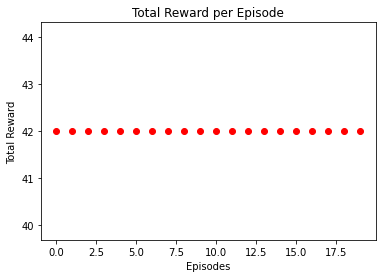

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

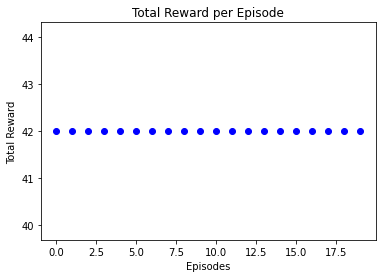

<IPython.core.display.Javascript object>

In [136]:
grid = widgets.Grid(2,2)

with grid.output_to(0,0):
  print('Evaluation of Q-Learning in Deterministic Environment')

with grid.output_to(0,1):
  print('Evaluation of Q-Learning in Stochastic Environment')

Q_sto_eval_reward_per_episode = list()
Q_det_eval_reward_per_episode = list()

'''Evaluation in Deterministic Environment'''

for each_episode in range(20):
  state= det_env.reset()
  done= False
  reward_per_episode= 0
  
  while not done:
    action= Q_agent.step(state= state)
    next_state, reward, done, info= det_env.step(action= action)
    state= next_state
    reward_per_episode += reward
  Q_det_eval_reward_per_episode.append(reward_per_episode)


'''Evaluation in Stochastic Environment'''

for each_episode in range(20):
  state= sto_environment.reset()
  done= False
  reward_per_episode= 0
  
  while not done:
    action= Q_agent.step(state= state)
    next_state, reward, done, info= sto_environment.step(action= action)
    state= next_state
    reward_per_episode += reward

  Q_sto_eval_reward_per_episode.append(reward_per_episode)

'''Plotting values'''

with grid.output_to(1,0):
  plt.title('Total Reward per Episode')
  plt.plot(Q_det_eval_reward_per_episode, 'ro')
  plt.xlabel('Episodes')
  plt.ylabel('Total Reward')

with grid.output_to(1,1):
  plt.title('Total Reward per Episode')
  plt.plot(Q_sto_eval_reward_per_episode, 'bo')
  plt.xlabel('Episodes')
  plt.ylabel('Total Reward')

#SARSA

In [137]:
class SARSA_Agent(RandomAgent):

  def __init__(self, env, discount_rate= 0.99, learning_rate= 0.1, epsilon= 1.0):
    ''' This class initializes a SARSA agent with gamma = 0.99, alpha = 0.1 and epsilon = 1.0'''
    super().__init__(env)
    self.epsilon= epsilon
    self.gamma= discount_rate
    self.alpha= learning_rate
    self.Q_table= np.zeros((self.observation_space.n, self.action_space.n))#Creates Q-table


  def step(self, state):
    '''This function decides the action takn by the agent based on the epsilon value. Takes an integer as input.'''
    Q_state= self.Q_table[state]
    greedy_action= np.argmax(Q_state)
    random_action= super().step(state)
    return random_action if random.random() < self.epsilon else greedy_action

  def train(self, experience):
    '''This function decides the action takn by the agent based on the epsilon value.'''
    state, action, next_state, next_action, reward, done= experience

    Q_next= 0 #If done, Q-value set to 0
    if done == False: 
      Q_next = self.Q_table[next_state][next_action]
      
    self.Q_table[state][action] += self.alpha * (reward + self.gamma * Q_next - self.Q_table[state][action]) #Update function

    '''Setting exponential decay'''
    if done == True:
      self.epsilon= self.epsilon * 0.99

###Deterministic Environment SARSA

In [138]:
MAX_TIMESTEPS = 50
det_environment = RoadToQatar(MAX_TIMESTEPS, 'Deterministic')
episodes= 1000

In [139]:
SARSA_agent= SARSA_Agent(env = det_environment)

SARSA_det_reached = 0
total_reward= 0

SARSA_det_bad_state= list()
SARSA_det_epsilon_decay= list()
SARSA_det_reward_per_episode= list()
SARSA_det_timestep_per_episode= list()
SARSA_det_cumulative_reward = list()

for each_episode in range(episodes):
  state = det_environment.reset()
  done = False
  reward_per_episode = 0
  timestep_per_episode = 0
  bad_state = 0

  action= SARSA_agent.step(state = state)
  while not done:
    next_action= SARSA_agent.step(state= state)
    next_state, reward, done, info= det_environment.step(action= action)
    SARSA_agent.train(experience= (state, action, next_state, next_action, reward, done))
    state= next_state
    action= next_action

    reward_per_episode += reward
    total_reward += reward
    timestep_per_episode += 1
    if reward < 0:
      bad_state += 1

  SARSA_det_bad_state.append(bad_state)
  SARSA_det_timestep_per_episode.append(timestep_per_episode)
  SARSA_det_epsilon_decay.append(SARSA_agent.epsilon)
  SARSA_det_reward_per_episode.append(reward_per_episode)
  SARSA_det_cumulative_reward.append(total_reward)

  if done == True and det_environment.timestep < MAX_TIMESTEPS:
    # Agent has reached the goal
    SARSA_det_reached += 1

print('Training Agent using SARSA in Deterministic Environment')

print('\nNumber of times agent REACHED goal: {} \nNumber of times agent DID NOT REACH goal: {}'.format(SARSA_det_reached, episodes - SARSA_det_reached))
print('Total reward at the end of training: {}'.format(total_reward))

print('\nQ-table\n')
print(Q_agent.Q_table)

Training Agent using SARSA in Deterministic Environment

Number of times agent REACHED goal: 986 
Number of times agent DID NOT REACH goal: 14
Total reward at the end of training: 39642

Q-table

[[40.4567611  16.79351374 17.91513785 19.48841147]
 [ 5.55206197 11.89631275 10.75156766 19.19838292]
 [-2.26437851  3.58161842  2.39209975 16.19507452]
 [ 0.76722981  2.42910667  1.63073045  4.42439756]
 [35.8149102  16.61994144 16.53844907 15.71833855]
 [10.79881876 19.0507504  -3.73327844 14.83745198]
 [-2.3639595   6.53250291  0.60779359  1.29280792]
 [ 0.19037672  1.45723277  0.60713625 -1.65182727]
 [39.20698    20.08084322 17.89244647 19.37760663]
 [18.92277463  9.06756819  6.20797584 18.1172022 ]
 [19.77122836 -2.3254811   1.83408056  2.31580198]
 [ 8.6052011   1.23598573  0.59402724  1.55344655]
 [18.27490597 19.61512239 29.502      16.99048149]
 [18.82456212 18.48343053 29.8        20.88250464]
 [16.56499943 11.23304164 20.         18.84337444]
 [ 0.          0.          0.          

###Stochastic Environment SARSA

In [131]:
MAX_TIMESTEPS = 50
sto_environment = RoadToQatar(MAX_TIMESTEPS,'Stochastic')
episodes= 1000

In [140]:
SARSA_agent = SARSA_Agent(env= sto_environment)

SARSA_sto_reached = 0
total_reward = 0

SARSA_sto_bad_state= list()
SARSA_sto_epsilon_decay= list()
SARSA_sto_reward_per_episode= list()
SARSA_sto_timestep_per_episode= list()
SARSA_sto_cumulative_reward = list()

for each_episode in range(episodes):
  state= sto_environment.reset()
  done= False
  reward_per_episode= 0
  timestep_per_episode= 0
  bad_state= 0

  action= SARSA_agent.step(state = state)
  while not done:
    next_action= SARSA_agent.step(state = state)
    next_state, reward, done, info = sto_environment.step(action = action)
    SARSA_agent.train(experience = (state, action, next_state, next_action, reward, done))
    state = next_state
    action = next_action

    reward_per_episode += reward
    total_reward += reward
    timestep_per_episode += 1

    if reward < 0:
      bad_state += 1

  SARSA_sto_bad_state.append(bad_state)
  SARSA_sto_timestep_per_episode.append(timestep_per_episode)
  SARSA_sto_epsilon_decay.append(SARSA_agent.epsilon)
  SARSA_sto_reward_per_episode.append(reward_per_episode)
  SARSA_sto_cumulative_reward.append(total_reward)

  if done == True and sto_environment.timestep < MAX_TIMESTEPS:
    # Agent has reached the goal
    SARSA_sto_reached += 1

print('Training Agent using SARSA in Stochastic Environment')

print('\nNumber of times agent REACHED goal: {} \nNumber of times agent DID NOT REACH goal: {}'.format(SARSA_sto_reached, episodes - SARSA_sto_reached))
print('Total reward at the end of training: {}'.format(total_reward))

print('\nQ-table\n')
print(Q_agent.Q_table)

Training Agent using SARSA in Stochastic Environment

Number of times agent REACHED goal: 975 
Number of times agent DID NOT REACH goal: 25
Total reward at the end of training: 39039

Q-table

[[40.4567611  16.79351374 17.91513785 19.48841147]
 [ 5.55206197 11.89631275 10.75156766 19.19838292]
 [-2.26437851  3.58161842  2.39209975 16.19507452]
 [ 0.76722981  2.42910667  1.63073045  4.42439756]
 [35.8149102  16.61994144 16.53844907 15.71833855]
 [10.79881876 19.0507504  -3.73327844 14.83745198]
 [-2.3639595   6.53250291  0.60779359  1.29280792]
 [ 0.19037672  1.45723277  0.60713625 -1.65182727]
 [39.20698    20.08084322 17.89244647 19.37760663]
 [18.92277463  9.06756819  6.20797584 18.1172022 ]
 [19.77122836 -2.3254811   1.83408056  2.31580198]
 [ 8.6052011   1.23598573  0.59402724  1.55344655]
 [18.27490597 19.61512239 29.502      16.99048149]
 [18.82456212 18.48343053 29.8        20.88250464]
 [16.56499943 11.23304164 20.         18.84337444]
 [ 0.          0.          0.          0. 

#EVALUATION OF SARSA

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Evaluation of SARSA in Deterministic Environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Evaluation of SARSA in Stochastic Environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

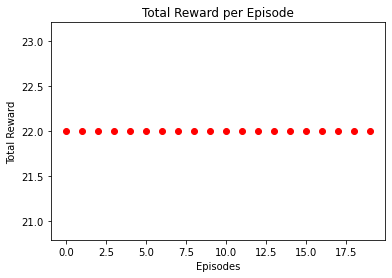

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

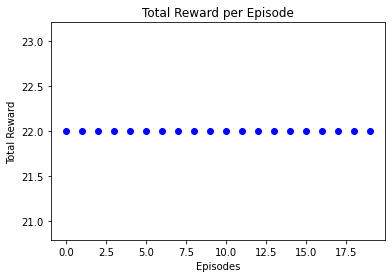

<IPython.core.display.Javascript object>

In [141]:
grid = widgets.Grid(2,2)

with grid.output_to(0,0):
  print('Evaluation of SARSA in Deterministic Environment')

with grid.output_to(0,1):
  print('Evaluation of SARSA in Stochastic Environment')

SARSA_sto_eval_reward_per_episode = list()
SARSA_det_eval_reward_per_episode = list()

'''Evaluation in Deterministic Environment'''

for each_episode in range(20):
  state= det_env.reset()
  done= False
  reward_per_episode= 0
  
  while not done:
    action= SARSA_agent.step(state= state)
    next_state, reward, done, info= det_env.step(action= action)
    state= next_state
    reward_per_episode += reward

  SARSA_det_eval_reward_per_episode.append(reward_per_episode)

'''Evaluation in Stochastic Environment'''

for each_episode in range(20):
  state= sto_environment.reset()
  done= False
  reward_per_episode= 0
  
  while not done:
    action= SARSA_agent.step(state= state)
    next_state, reward, done, info= sto_environment.step(action= action)
    state= next_state
    reward_per_episode += reward

  SARSA_sto_eval_reward_per_episode.append(reward_per_episode)

'''Plotting Values'''
  
with grid.output_to(1,0):
  plt.title('Total Reward per Episode')
  plt.plot(SARSA_det_eval_reward_per_episode, 'ro')
  plt.xlabel('Episodes')
  plt.ylabel('Total Reward')

with grid.output_to(1,1):
  plt.title('Total Reward per Episode')
  plt.plot(SARSA_sto_eval_reward_per_episode, 'bo')
  plt.xlabel('Episodes')
  plt.ylabel('Total Reward')

#Q-LEARNING vs SARSA

###Deterministic Environment

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

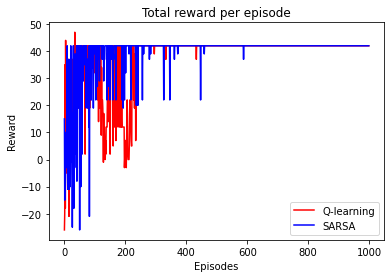

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

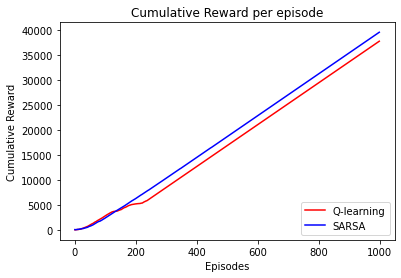

<IPython.core.display.Javascript object>

In [143]:
grid = widgets.Grid(1,2)

with grid.output_to(0,0):
  plt.title('Total reward per episode')
  plt.plot(Q_det_reward_per_episode, 'red')
  plt.plot(SARSA_det_reward_per_episode,'blue')
  plt.xlabel('Episodes')
  plt.ylabel('Reward')
  plt.legend(['Q-learning', 'SARSA'], loc ="lower right")

with grid.output_to(0,1):
  plt.title('Cumulative Reward per episode')
  plt.plot(Q_det_cumulative_reward,'red')
  plt.plot(SARSA_det_cumulative_reward,'blue')
  plt.ylabel('Cumulative Reward')
  plt.xlabel('Episodes')
  plt.legend(['Q-learning', 'SARSA'], loc ="lower right")

###Stochastic Environment

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

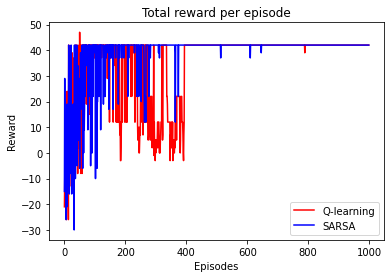

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

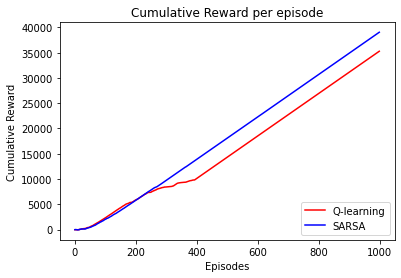

<IPython.core.display.Javascript object>

In [144]:
grid = widgets.Grid(1,2)

with grid.output_to(0,0):
  plt.title('Total reward per episode')
  plt.plot(Q_sto_reward_per_episode, 'red')
  plt.plot(SARSA_sto_reward_per_episode,'blue')
  plt.xlabel('Episodes')
  plt.ylabel('Reward')
  plt.legend(['Q-learning', 'SARSA'], loc ="lower right")

with grid.output_to(0,1):
  plt.title('Cumulative Reward per episode')
  plt.plot(Q_sto_cumulative_reward,'red')
  plt.plot(SARSA_sto_cumulative_reward,'blue')
  plt.ylabel('Cumulative Reward')
  plt.xlabel('Episodes')
  plt.legend(['Q-learning', 'SARSA'], loc ="lower right")

#GRAPHS

,,,,
,,,,
,,,,
,,,,
,,,,
,,,,
,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Total reward per episode


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epsilon decay


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Average number of timesteps per episode


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Average number of times agent 
receives penalty per episode


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Overall percentage of reaching the goal


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cumulative reward per episode


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performance of Q-learning agent in 
Deterministic Environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

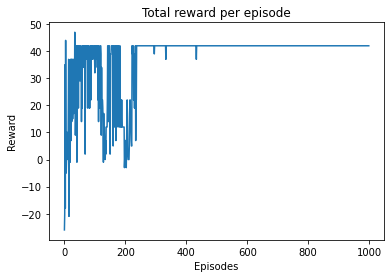

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

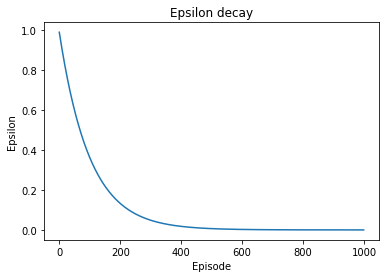

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

12.043


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3.784


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

90.60000000000001 %


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

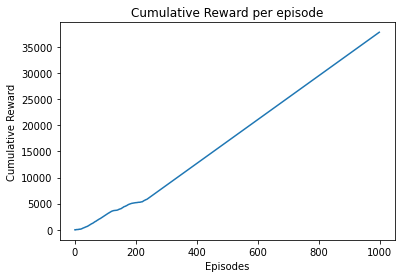

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performance of Q-learning agent in 
Stochastic Environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

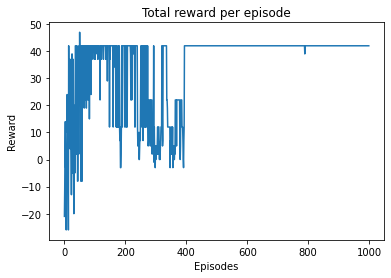

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

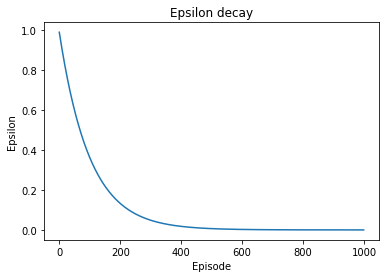

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

15.022


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1.135


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

85.5 %


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

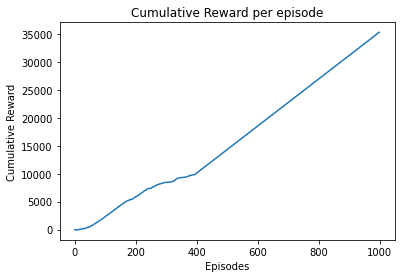

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performance of SARSA agent in 
Deterministic Environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

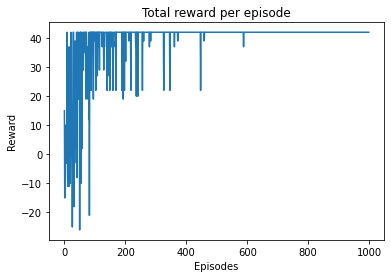

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

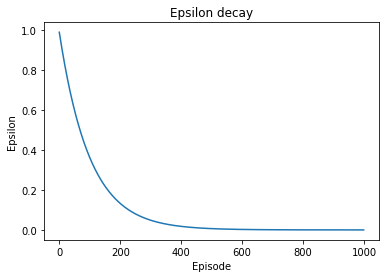

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

9.014


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1.179


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

85.5 %


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

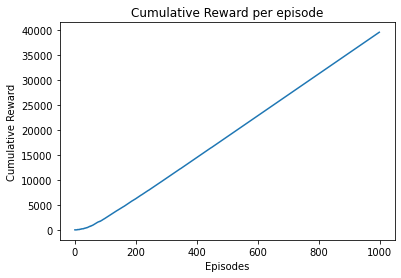

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performance of SARSA agent in 
Stochastic Environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

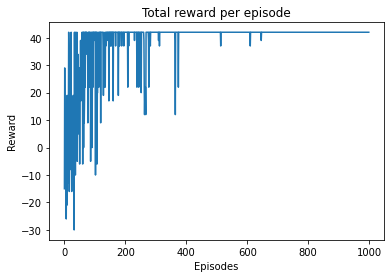

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

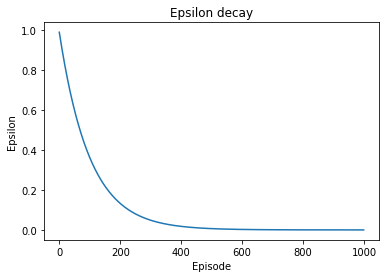

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

9.649


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1.209


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

85.5 %


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

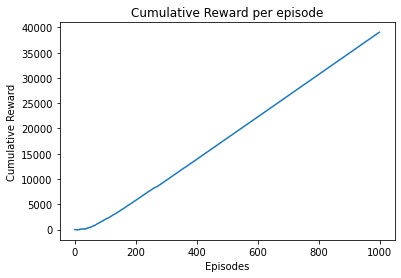

<IPython.core.display.Javascript object>

In [152]:
grid= widgets.Grid(7, 5)

#Metrics

with grid.output_to(1, 0):
  print(' Total reward per episode')
with grid.output_to(2, 0):
  print('Epsilon decay')
with grid.output_to(3, 0):
  print('Average number of timesteps per episode')
with grid.output_to(4, 0):
  print('Average number of times agent \nreceives penalty per episode')
with grid.output_to(5, 0):
  print('Overall percentage of reaching the goal')
with grid.output_to(6,0):
  print('Cumulative reward per episode')


#Q-det

with grid.output_to(0, 1):
  print('Performance of Q-learning agent in \nDeterministic Environment')

with grid.output_to(1, 1):
  plt.title('Total reward per episode')
  plt.plot(Q_det_reward_per_episode)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')

with grid.output_to(2, 1):
  plt.title('Epsilon decay')
  plt.plot(Q_det_epsilon_decay)
  plt.xlabel('Episode')
  plt.ylabel('Epsilon')

with grid.output_to(3, 1):
  print(np.mean(np.array(Q_det_timestep_per_episode)))

with grid.output_to(4, 1):
  print(np.mean(np.array(Q_det_bad_state)))

with grid.output_to(5, 1):
  print('{} %'.format((Q_det_reached/episodes)*100))

with grid.output_to(6,1):
  plt.title('Cumulative Reward per episode')
  plt.plot(Q_det_cumulative_reward)
  plt.ylabel('Cumulative Reward')
  plt.xlabel('Episodes')


#Q-sto

with grid.output_to(0, 2):
  print('Performance of Q-learning agent in \nStochastic Environment')

with grid.output_to(1, 2):
  plt.title('Total reward per episode')
  plt.plot(Q_sto_reward_per_episode)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')

with grid.output_to(2, 2):
  plt.title('Epsilon decay')
  plt.plot(Q_sto_epsilon_decay)
  plt.xlabel('Episode')
  plt.ylabel('Epsilon')

with grid.output_to(3, 2):
  print(np.mean(np.array(Q_sto_timestep_per_episode)))

with grid.output_to(4, 2):
  print(np.mean(np.array(Q_sto_bad_state)))

with grid.output_to(5, 2):
  print('{} %'.format((Q_sto_reached/episodes)*100))

with grid.output_to(6,2):
  plt.title('Cumulative Reward per episode')
  plt.plot(Q_sto_cumulative_reward)
  plt.ylabel('Cumulative Reward')
  plt.xlabel('Episodes')
  
#SARSA-det

with grid.output_to(0, 3):
  print('Performance of SARSA agent in \nDeterministic Environment')

with grid.output_to(1, 3):
  plt.title('Total reward per episode')
  plt.plot(SARSA_det_reward_per_episode)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')

with grid.output_to(2, 3):
  plt.title('Epsilon decay')
  plt.plot(SARSA_det_epsilon_decay)
  plt.xlabel('Episode')
  plt.ylabel('Epsilon')

with grid.output_to(3, 3):
  print(np.mean(np.array(SARSA_det_timestep_per_episode)))

with grid.output_to(4, 3):
  print(np.mean(np.array(SARSA_det_bad_state)))

with grid.output_to(5, 3):
  print('{} %'.format((Q_sto_reached/episodes)*100))

with grid.output_to(6,3):
  plt.title('Cumulative Reward per episode')
  plt.plot(SARSA_det_cumulative_reward)
  plt.ylabel('Cumulative Reward')
  plt.xlabel('Episodes')
  

#SARSA-sto

with grid.output_to(0, 4):
  print('Performance of SARSA agent in \nStochastic Environment')

with grid.output_to(1, 4):
  plt.title('Total reward per episode')
  plt.plot(SARSA_sto_reward_per_episode)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')

with grid.output_to(2, 4):
  plt.title('Epsilon decay')
  plt.plot(SARSA_sto_epsilon_decay)
  plt.xlabel('Episode')
  plt.ylabel('Epsilon')

with grid.output_to(3, 4):
  print(np.mean(np.array(SARSA_sto_timestep_per_episode)))

with grid.output_to(4, 4):
  print(np.mean(np.array(SARSA_sto_bad_state)))

with grid.output_to(5, 4):
  print('{} %'.format((Q_sto_reached/episodes)*100))

with grid.output_to(6,4):
  plt.title('Cumulative Reward per episode')
  plt.plot(SARSA_sto_cumulative_reward)
  plt.ylabel('Cumulative Reward')
  plt.xlabel('Episodes')
    

#HYPERPARAMETER TUNING

##Discount Factor

,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Deterministic Environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Stochastic Environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

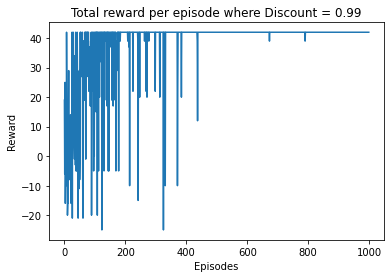

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

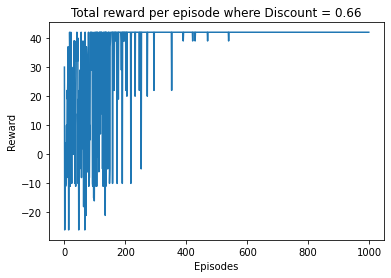

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

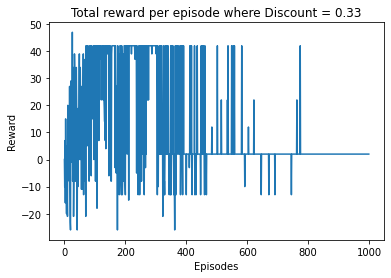

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

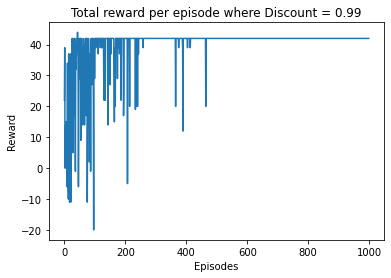

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

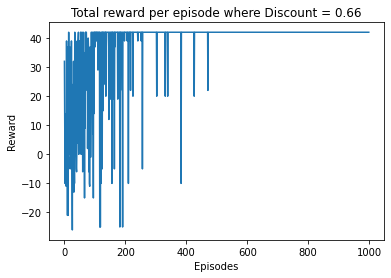

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

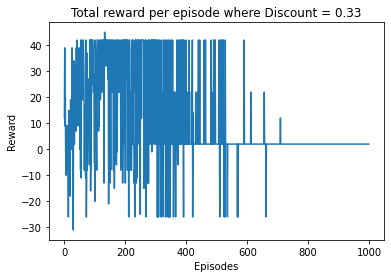

<IPython.core.display.Javascript object>

In [174]:
index= 1
episodes = 1000
discounts= [0.99, 0.66, 0.33]
grid= widgets.Grid(2, len(discounts)+1)

with grid.output_to(0, 0):
  print('Deterministic Environment')
with grid.output_to(1, 0):
  print('Stochastic Environment')

#----Deterministic Env----------
for x in discounts:
  environment = RoadToQatar(MAX_TIMESTEPS,'Deterministic')
  SARSA_agent= SARSA_Agent(env= environment, discount_rate= x)
  reward_list= list()
  for each_episode in range(episodes):
    state= environment.reset()
    done= False
    reward_per_episode= 0
    action= SARSA_agent.step(state = state)
    while not done:
      next_action= SARSA_agent.step(state = state)
      next_state, reward, done, info = environment.step(action = action)
      SARSA_agent.train(experience = (state, action, next_state, next_action, reward, done))
      state = next_state
      action = next_action
      reward_per_episode += reward  
    reward_list.append(reward_per_episode)

  with grid.output_to(0, index):
    plt.title('Total reward per episode where Discount = ' + str(x))
    plt.plot(reward_list)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
  index += 1

#----Stochastic Env----------

index = 1
for x in discounts:
  environment = RoadToQatar(MAX_TIMESTEPS,'Stochastic')
  SARSA_agent= SARSA_Agent(env= environment, discount_rate= x)
  reward_list= list()
  for each_episode in range(episodes):
    state= environment.reset()
    done= False
    reward_per_episode= 0
    action= SARSA_agent.step(state = state)
    while not done:
      next_action= SARSA_agent.step(state = state)
      next_state, reward, done, info = environment.step(action = action)
      SARSA_agent.train(experience = (state, action, next_state, next_action, reward, done))
      state = next_state
      action = next_action
      reward_per_episode += reward  
    reward_list.append(reward_per_episode)

  with grid.output_to(1, index):
    plt.title('Total reward per episode where Discount = ' + str(x))
    plt.plot(reward_list)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
  index += 1

##Number of Episodes

,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Deterministic Environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Stochastic Environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

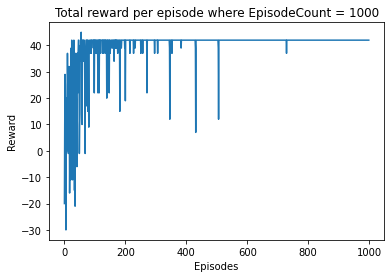

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

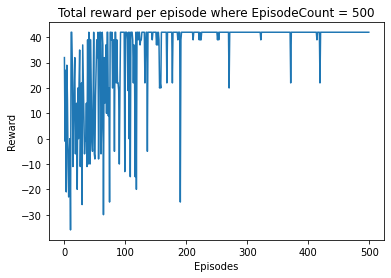

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

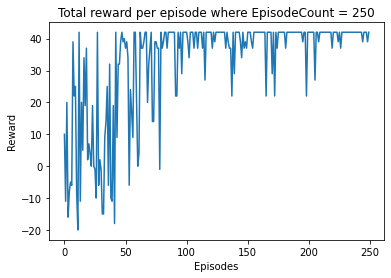

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

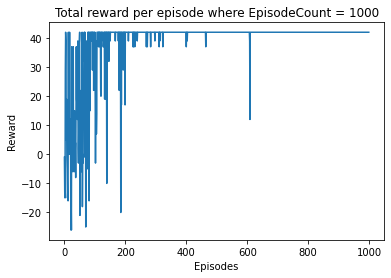

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

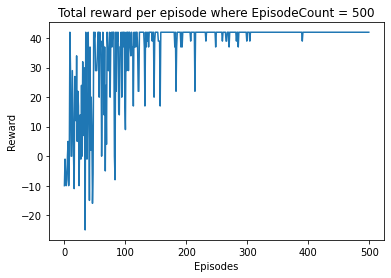

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

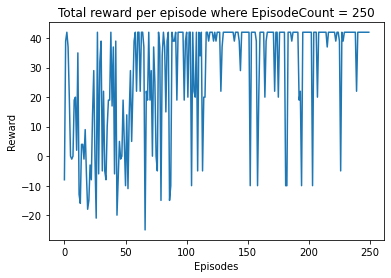

<IPython.core.display.Javascript object>

In [173]:
index= 1
episode_list = [1000, 500, 250]
grid= widgets.Grid(2, len(episode_list)+1)

with grid.output_to(0,0):
  print('Deterministic Environment')
with grid.output_to(1,0):
  print('Stochastic Environment')

#----Deterministic Env----------

for x in episode_list:
  environment= RoadToQatar(MAX_TIMESTEPS, 'Deterministic')
  SARSA_agent= SARSA_Agent(env= environment)
  reward_list= list()
  for each_episode in range(x):
    state= environment.reset()
    done= False
    reward_per_episode= 0
    action = SARSA_agent.step(state = state)
    while not done:
      next_action= SARSA_agent.step(state= state)
      next_state, reward, done, info= environment.step(action= action)
      SARSA_agent.train(experience= (state, action, next_state, next_action, reward, done))
      state= next_state
      action = next_action
      reward_per_episode += reward
    reward_list.append(reward_per_episode)

  with grid.output_to(0, index):
    plt.title('Total reward per episode where EpisodeCount = ' + str(x))
    plt.plot(reward_list)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
  index += 1

#----Stochastic Env----------

index = 1

for x in episode_list:
  environment= RoadToQatar(MAX_TIMESTEPS, 'Stochastic')
  SARSA_agent= SARSA_Agent(env= environment)
  reward_list= list()
  for each_episode in range(x):
    state= environment.reset()
    done= False
    reward_per_episode= 0
    action = SARSA_agent.step(state=state)
    while not done:
      next_action= SARSA_agent.step(state= state)
      next_state, reward, done, info= environment.step(action= action)
      SARSA_agent.train(experience= (state, action, next_state, next_action, reward, done))
      state= next_state
      action = next_action
      reward_per_episode += reward
    reward_list.append(reward_per_episode)

  with grid.output_to(1, index):
    plt.title('Total reward per episode where EpisodeCount = ' + str(x))
    plt.plot(reward_list)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
  index += 1